<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_5928\4267072737.py:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feat_imp_df, palette='coolwarm')


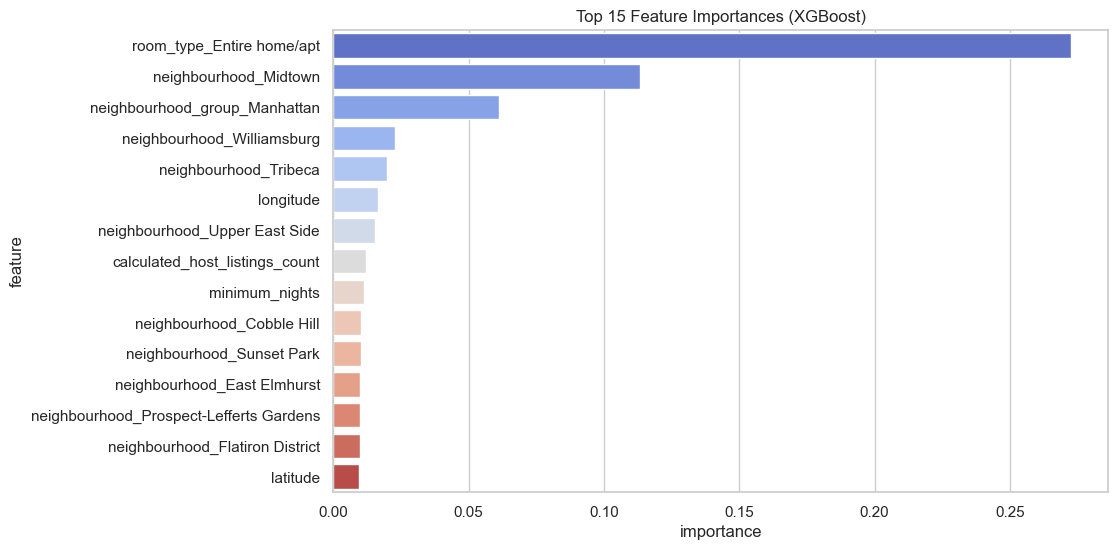

Predicted Price for sample listing: $103.45


In [7]:
# ----------------------------
# 1. Import Libraries
# ----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ----------------------------
# 2. Load Dataset
# ----------------------------
df = pd.read_csv('AB_NYC_2019.csv')
print(df.info())

# ----------------------------
# 3. Data Cleaning
# ----------------------------
df = df[df['price'] > 0]  # remove zero prices
df = df[df['price'] < df['price'].quantile(0.99)]  # remove top 1% outliers

# Convert last_review to datetime
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

# Fill missing values
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
df['name'] = df['name'].fillna('')
df['host_name'] = df['host_name'].fillna('Unknown')

# ----------------------------
# 4. Feature Engineering
# ----------------------------
# Extract year/month from last_review
df['last_review_year'] = df['last_review'].dt.year.fillna(0).astype(int)
df['last_review_month'] = df['last_review'].dt.month.fillna(0).astype(int)

# ----------------------------
# 5. Features & Target
# ----------------------------
cat_features = ['room_type', 'neighbourhood_group', 'neighbourhood']
num_features = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
                'reviews_per_month', 'calculated_host_listings_count', 'availability_365',
                'last_review_year', 'last_review_month']

X = df[num_features + cat_features]
y = df['price']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# ----------------------------
# 6. Preprocessing Pipelines
# ----------------------------
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # corrected
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
])

# ----------------------------
# 7. Modeling Pipelines
# ----------------------------
# Linear Regression
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# XGBoost Regressor
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42))
])

# ----------------------------
# 8. Fit & Evaluate Models
# ----------------------------
def evaluate_model(pipeline, X_test, y_test):
    y_pred = pipeline.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

# Fit and evaluate Linear Regression
lr_pipeline.fit(X_train, y_train)
rmse_lr, r2_lr = evaluate_model(lr_pipeline, X_test, y_test)
print(f"Linear Regression RMSE: {rmse_lr:.2f}, R2: {r2_lr:.2f}")

# Fit and evaluate XGBoost
xgb_pipeline.fit(X_train, y_train)
rmse_xgb, r2_xgb = evaluate_model(xgb_pipeline, X_test, y_test)
print(f"XGBoost RMSE: {rmse_xgb:.2f}, R2: {r2_xgb:.2f}")

# ----------------------------
# 9. Feature Importance (XGBoost)
# ----------------------------
# Extract numeric + OHE feature names
num_names = num_features
cat_encoder = xgb_pipeline.named_steps['preprocessor'].transformers_[1][1]['ohe']
cat_names = cat_encoder.get_feature_names_out(cat_features)
feature_names = list(num_names) + list(cat_names)

importances = xgb_pipeline.named_steps['regressor'].feature_importances_

feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df, palette='coolwarm')
plt.title("Top 15 Feature Importances (XGBoost)")
plt.show()

# ----------------------------
# 10. Predict Example
# ----------------------------
sample_listing = X_test.iloc[0:1]
predicted_price = xgb_pipeline.predict(sample_listing)[0]
print(f"Predicted Price for sample listing: ${predicted_price:.2f}")


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_5928\60606096.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


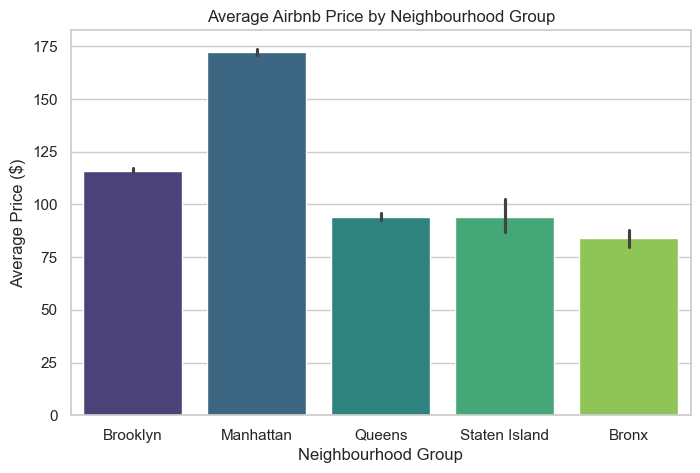

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_5928\60606096.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


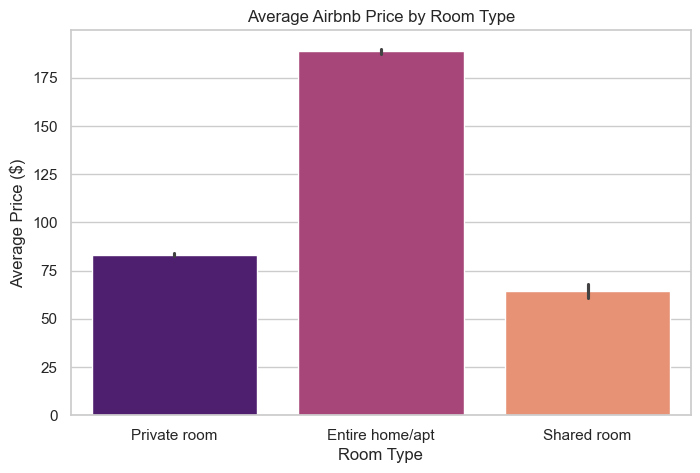

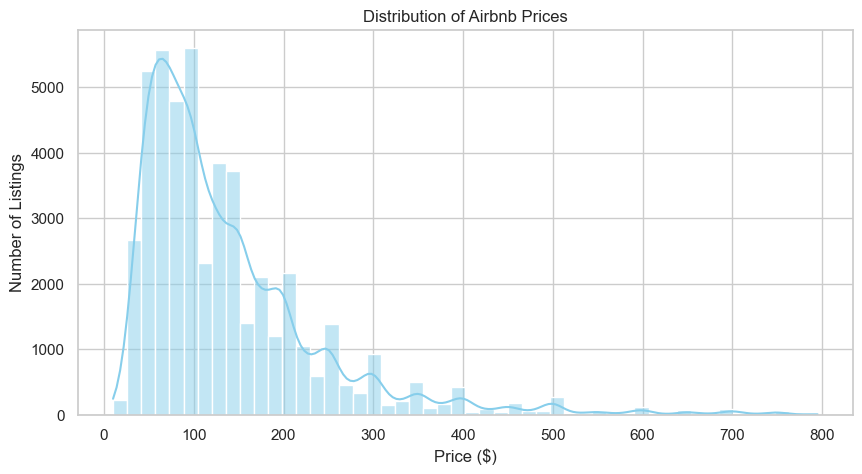

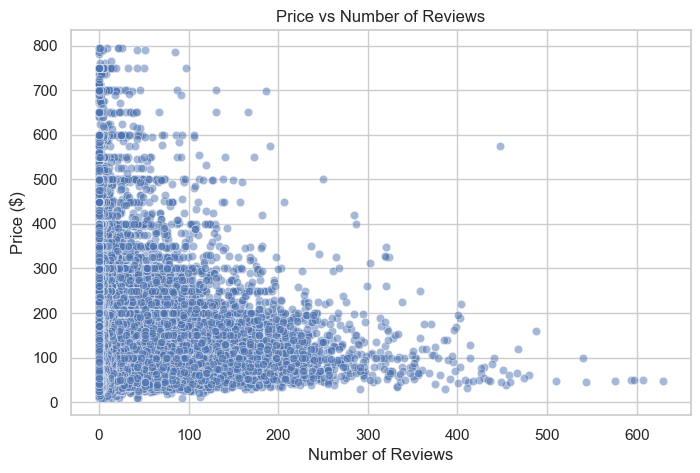

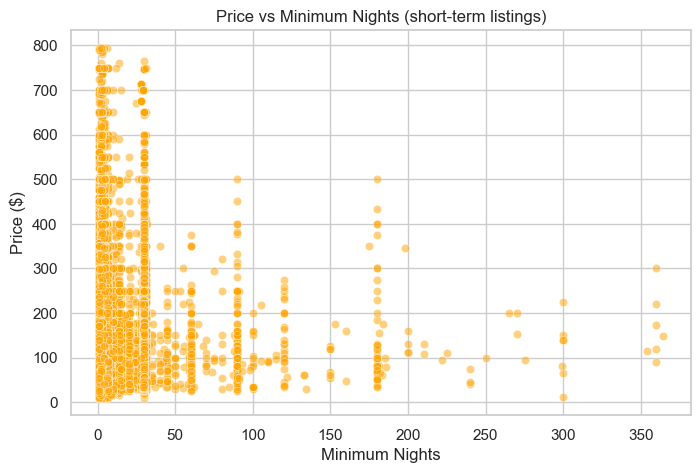

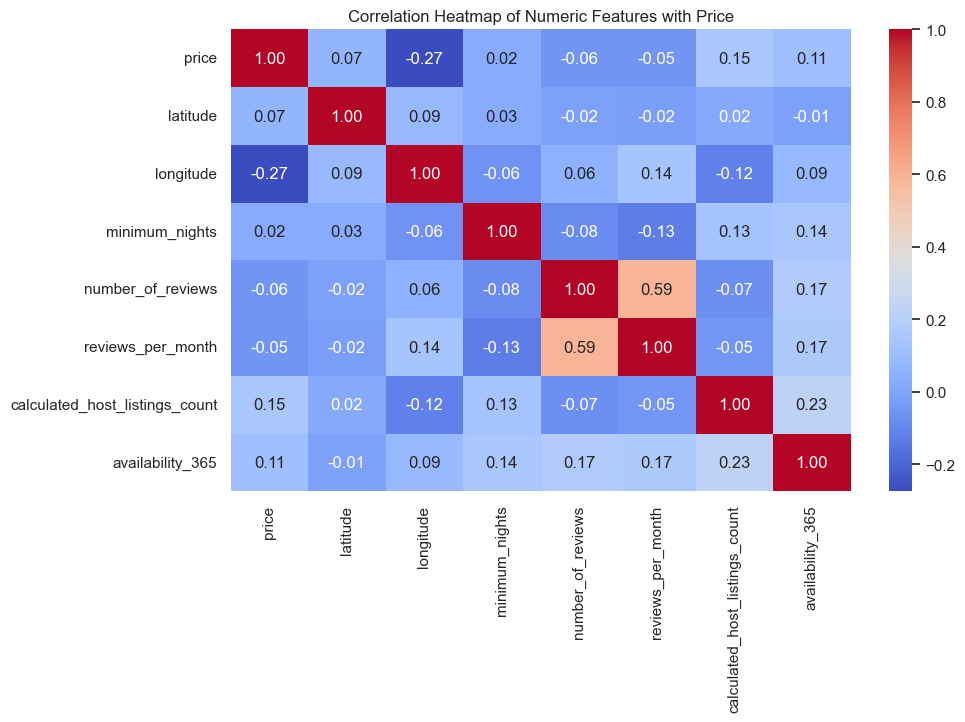

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")

# ----------------------------
# 1. Average Price by Neighbourhood Group
# ----------------------------
plt.figure(figsize=(8,5))
sns.barplot(
    x='neighbourhood_group',  # corrected column name
    y='price',
    data=df,
    estimator=np.mean,
    palette="viridis"
)
plt.title("Average Airbnb Price by Neighbourhood Group")
plt.xlabel("Neighbourhood Group")
plt.ylabel("Average Price ($)")
plt.show()

# ----------------------------
# 2. Average Price by Room Type
# ----------------------------
plt.figure(figsize=(8,5))
sns.barplot(
    x='room_type',
    y='price',
    data=df,
    estimator=np.mean,
    palette="magma"
)
plt.title("Average Airbnb Price by Room Type")
plt.xlabel("Room Type")
plt.ylabel("Average Price ($)")
plt.show()

# ----------------------------
# 3. Price Distribution
# ----------------------------
plt.figure(figsize=(10,5))
sns.histplot(df['price'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Airbnb Prices")
plt.xlabel("Price ($)")
plt.ylabel("Number of Listings")
plt.show()

# ----------------------------
# 4. Price vs Number of Reviews
# ----------------------------
plt.figure(figsize=(8,5))
sns.scatterplot(
    x='number_of_reviews',
    y='price',
    data=df,
    alpha=0.5
)
plt.title("Price vs Number of Reviews")
plt.xlabel("Number of Reviews")
plt.ylabel("Price ($)")
plt.show()

# ----------------------------
# 5. Price vs Minimum Nights (short-term listings)
# ----------------------------
plt.figure(figsize=(8,5))
sns.scatterplot(
    x='minimum_nights',
    y='price',
    data=df[df['minimum_nights'] < 365],  # filter extreme long-term listings
    alpha=0.5,
    color='orange'
)
plt.title("Price vs Minimum Nights (short-term listings)")
plt.xlabel("Minimum Nights")
plt.ylabel("Price ($)")
plt.show()

# ----------------------------
# 6. Correlation Heatmap for Numeric Features
# ----------------------------
numeric_cols = [
    'price', 'latitude', 'longitude', 'minimum_nights', 
    'number_of_reviews', 'reviews_per_month', 
    'calculated_host_listings_count', 'availability_365'
]

plt.figure(figsize=(10,6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features with Price")
plt.show()


In [9]:
# Make a custom listing
custom_listing = pd.DataFrame({
    'latitude': [40.7128],
    'longitude': [-74.0060],
    'minimum_nights': [3],
    'number_of_reviews': [50],
    'reviews_per_month': [1.2],
    'calculated_host_listings_count': [2],
    'availability_365': [180],
    'last_review_year': [2023],
    'last_review_month': [11],
    'room_type': ['Entire home/apt'],
    'neighbourhood_group': ['Manhattan'],
    'neighbourhood': ['Midtown']
})

predicted_price = xgb_pipeline.predict(custom_listing)[0]
print(f"Predicted Price for custom listing: ${predicted_price:.2f}")


Predicted Price for custom listing: $353.22
